## Natural Language Processing

In this part you will have to work with different versions of BERT model and use it to solve the [RuCoLa](https://rucola-benchmark.com/) task.


In the task you should perform all the model training on `in_domain_train.csv` data and evaluate your models on `in_domain_dev.csv`. Note that you do not need `test.csv`.

Use **[accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)** and **[MCC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)** metrics for scoring.

### 1. Data analysis 


* 1.1 [Download](https://github.com/RussianNLP/RuCoLA/tree/main/data) the data(you need only `in_domain_train.csv` for training and  `in_domain_dev.csv` for the evaluation) and calculate basic statistics (example number, class distribution, mean sentence length, number of unique words, etc.) and make visualizations, if necessary. 

* 1.2. Split the data from `in_domain_train.csv` into train and val (`val_size = 10%`). Do not forget to fix `random_state` for reproducibility.

### 2. Fine-tune RuBERT

* 2.0 Study the [tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) on BERT model fine-tuning.

**Note:** this part is not graded. However, you may find the material from the tutorial useful  for the successful task completion.

* 2.1 Take RuBert model (BERT for the Russian language). You may use any of the BERT-like models for the Russian language from [Hugging Face](https://huggingface.co/) project. For example, you may use [`sberbank-ai/ruBert-base`](https://huggingface.co/sberbank-ai/ruBert-base) or [`DeepPavlov/rubert-base-cased`](https://huggingface.co/DeepPavlov/rubert-base-cased).


* 2.2  Fine-tune RuBERT on RuCoLa train part created in 1.2. Do not forget about validation in process of training on val set created in 1.2. Select optimal epochs number, using the statistics on the val set.

* 2.3  Evaluate your fine-tuned model (use accuracy and MCC metrics and `in_domain_dev.csv` for the evaluation), analyze the results and make conclusions.

### 3. Fine-tune mBERT on RuCoLa

* 3.1 Now take a multilingual BERT model (BERT for the Russian language), or simply [mBERT](https://huggingface.co/bert-base-multilingual-cased) from [Hugging Face](https://huggingface.co/) project. 


* 3.2 Similarly to 2, fine-tune mBERT on RuCoLa train part created in 1.2. Do not forget about validation in process of training on val set created in 1.2. Select optimal epochs number, using the statistics on the val set.

* 3.3 Evaluate your fine-tuned model (use accuracy and MCC metrics and `in_domain_dev.csv` for the evaluation), analyze the results and make conclusions.

### 4. Fine-tune mBERT on RuCoLa

* 4.1 Augment the training data with English examples from [CoLa](https://nyu-mll.github.io/CoLA/) dataset, which is the English analogue of RuCoLa (you probably know it if you studies the tutorial in 2.0). You need `in_domain_train.tsv` which can be found [here](https://github.com/nyu-mll/CoLA-baselines/tree/master/acceptability_corpus/cola_public/raw).


* 4.2 Similarly to 3, fine-tune mBERT from 2.1 on RuCoLa train part created in 1.2 + `in_domain_train.tsv` from CoLa dataset. Do not forget about validation in process of training on val set created in 1.2. Select optimal epochs number, using the statistics on the val set.

* 4.3 Evaluate your fine-tuned model (use accuracy and MCC metrics and `in_domain_dev.csv` for the evaluation), analyze the results and make conclusions.


### 5. Summary & results analysis


* 5.1 Compare the results of the all the tested models. First, compare them between each other, then with other models on [RuCoLa leaderboard](https://rucola-benchmark.com/leaderboard). Do not forget to mention, how the English data influences mBERT results.


* 5.2 Propose, how you may improve the model score (write at least three ideas).

### 1. Data analysis

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [50]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [51]:
!pip install transformers

### Download RuCoLa Dataset

We'll use the `wget` package to download the dataset to the Colab instance's file system.

In [52]:
!pip install wget

The dataset is hosted on GitHub in this [repo](https://github.com/RussianNLP/RuCoLA/tree/main/data)

In [53]:
import wget
import os

# The URL for the dataset files
url_common = 'https://raw.githubusercontent.com/RussianNLP/RuCoLA/main/data/'

files_to_download = ['in_domain_train.csv', 'in_domain_dev.csv']

# Download the files (if we haven't already)
directory = 'fp_part2_data' # folder to save dataset files
for file in files_to_download:
  if not os.path.exists(f'./{directory}'):
    os.mkdir(f'./{directory}/')
    print("Directory '% s' created \n" % directory)

  if not os.path.exists(f'./{directory}/{file}'):
    url = url_common + file
    print(f'Downloading dataset "{file}" ...')
    wget.download(url, f'./{directory}/')
    print(f'Completed!\n')

### Parse

We'll use pandas to parse the `in-domain` training set and look at a few of its properties and data points.

In [54]:
import pandas as pd

# Load the train dataset into a pandas dataframe.
df_tr_RuCoLa = pd.read_csv(f"./{directory}/{files_to_download[0]}")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_tr_RuCoLa.shape[0]))

# Display 10 random rows from the data.
df_tr_RuCoLa.sample(10)

Number of training sentences: 7,869



,id,sentence,acceptable,error_type,detailed_source
7794,7794,В Белоруссии либеральные газеты не остались.,0,Semantics,Paducheva2013
503,503,"Иван хочет, чтобы Петр пригласил его к себе.",1,0,Testelets
6496,6496,Дубровский назначил Кистеневскую рощу местом с...,1,0,Paducheva2004
5046,5046,"Сейчас есть занятия по химии, физике.",0,Semantics,Seliverstova
2298,2298,"Вечером я дописывал ""Романтиков"".",1,0,Paducheva2010
5446,5446,Я застал его на даче.,1,0,Paducheva2004
1703,1703,Михаил повернулся на оклик и стал вглядываться...,1,0,USE5
7070,7070,Я принес цветы для и обаятельной девушки.,0,Syntax,Testelets
2233,2233,Он надеялся опубликовать и познакомить читател...,0,Syntax,USE8
5038,5038,Он взял платок из кармана.,0,Semantics,Seliverstova


The two properties we actually care about are the the `sentence` and its `acceptable`, which is referred to as the "acceptibility judgment" (0=unacceptable, 1=acceptable).

Here are five sentences which are labeled as not grammatically acceptible.

In [55]:
df_tr_RuCoLa.loc[df_tr_RuCoLa.acceptable == 0].sample(5)[['sentence', 'acceptable', 'error_type']]

,sentence,acceptable,error_type
1537,Возле меня стояло такси.,0,Semantics
4421,Приступая к описанию недавних и столь странных...,0,Syntax
5795,"Иван закрыл глаза, чтобы он не увидел происход...",0,Syntax
2396,"Брюсов увлекается декадентством, убежденным, ч...",0,Syntax
7434,"Он был когда-то литератор, огорчен и не признан.",0,Syntax




Let's extract the sentences and labels of our training set as numpy ndarrays.

In [56]:
# Get the lists of sentences and their labels.
sentences_tr_RuCoLa = df_tr_RuCoLa.sentence.values
labels_tr_RuCoLa = df_tr_RuCoLa.acceptable.values
sentences_tr_RuCoLa[:5]

array(['Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.',
       'Этим летом не никуда ездили.',
       'Только Иван выразил какую бы то ни было готовность помочь.',
       'Теперь ты видишь собственными глазами, как тут хорошо.',
       'На поверку вся теория оказалась полной чепухой.'], dtype=object)

Let us evaluate class distribution for the `acceptable` feature

In [57]:
import matplotlib.pyplot as plt

def plot_bar(data: pd.DataFrame):
  plt.figure(figsize=(5, 3))
  data.value_counts().plot(kind='bar', edgecolor='black', zorder=2);
  plt.xticks(rotation=0)
  plt.grid(zorder=0)
  plt.title(f'Class distribution of "{data.name}" feature');

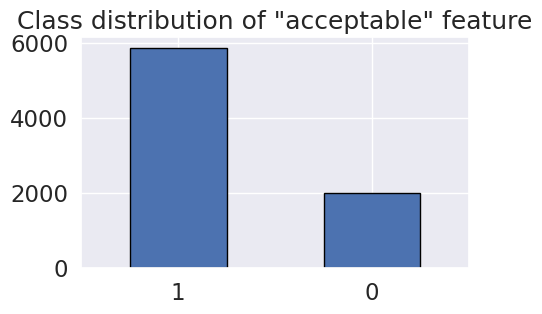

In [58]:
plot_bar(df_tr_RuCoLa.acceptable)

So, classes are imbalanced. We will take this observation into account choosing a quality metric.

Let us calculate mean sentence length in characters:

In [59]:
len_in_chars = df_tr_RuCoLa.sentence.apply(len)
print(f'An average sentence consists of {round(len_in_chars.mean())} characters')

An average sentence consists of 55 characters


Let us calculate mean sentence length in words:

In [60]:
import re

def remove_punctuation(x: str):
  '''
  This function is used to remove punctuation from lowercased sentences
  '''
  return re.sub(r'[^\w\s]', '', x.lower())

In [61]:
len_in_words = df_tr_RuCoLa.sentence.apply(lambda x: (len(remove_punctuation(x).split())))

# Print length of an average sentence
print(f'An average sentence consists   of {round(len_in_words.mean())} words')

# Print length of the shortest sentence
print(f'The shortest sentence consists of {round(len_in_words.min())} words')

# Print length of the longest sentence
print(f'The longest sentence consists  of {round(len_in_words.max())} words')

An average sentence consists   of 9 words
The shortest sentence consists of 3 words
The longest sentence consists  of 25 words


**Number of unique words**

To calculate the number of unique words used in the training dataset we will perform the following steps:
- make each word in a sentence lower case;
- remove punctuation from each sentence (type: str);
- split each sentence (type: str) into a list by space;
- convert each sentence (type: list) into a set to drop duplicates;
- union all sets obtained above into a final set;
- calculate the length of the final set.

In [62]:
def make_set(x: str):
  x = remove_punctuation(x)
  return set(x.split())

In [63]:
word_sets = df_tr_RuCoLa.sentence.apply(lambda x: make_set(x)).values
word_sets[:3] # some examples

array([{'прячущаяся', 'от', 'в', 'лунного', 'на', 'поехала', 'ивану', 'балконе', 'решетка', 'погрозила', 'и', 'возникла', 'пальцем', 'сторону', 'фигура', 'вдруг', 'света', 'таинственная', 'беззвучно'},
       {'никуда', 'этим', 'летом', 'не', 'ездили'},
       {'было', 'готовность', 'иван', 'только', 'ни', 'то', 'бы', 'какую', 'помочь', 'выразил'}],
      dtype=object)

In [64]:
final_set = set()
for word_set in word_sets:
  final_set |=  word_set # union of sets
final_set = sorted(final_set)

In [65]:
print('Excerpt from the final set of unique words:')
print(*final_set[2020:2023], sep=',\n', end='.')

Excerpt from the final set of unique words:
вступать,
вступая,
вступительные.

In [66]:
print('Number of unique words in training dataset: ', len(final_set))

Number of unique words in training dataset:  18006


### 1.5. Split the data from "in_domain_train.csv" into train and val (val_size = 10%).

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
df_train_RuCoLa, df_val_RuCoLa = train_test_split(df_tr_RuCoLa, test_size=0.1, stratify=df_tr_RuCoLa.acceptable, random_state=42)

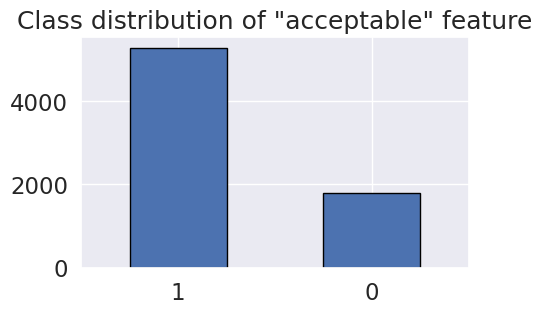

In [69]:
plot_bar(df_train_RuCoLa.acceptable)

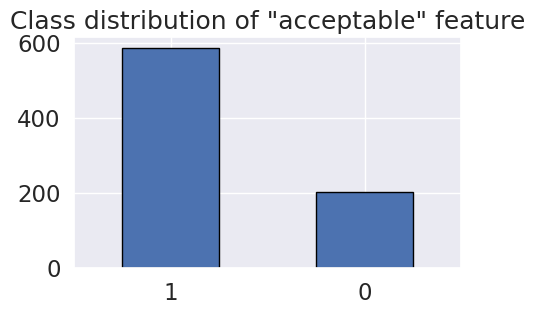

In [70]:
plot_bar(df_val_RuCoLa.acceptable)

Note: the split above shown only for demonstration, we will split tokenized text for train and validation purposes (please refer to paragraph 2.4 for the details).

# 2. Fine-tune RuBERT

## 2.1. Take RuBert model

In this section, we will transform our dataset into the format that RuBERT can be trained on.


To feed our text to RuBERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with RuBERT - the below cell will download this for us. We'll be using the "uncased" version here.


In [71]:
from transformers import AutoTokenizer

# Load the ruBERT tokenizer.
print('Loading ruBERT tokenizer...')
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
print('Completed!')


Loading ruBERT tokenizer...
Completed!


Let's apply the tokenizer to one sentence just to see the output.


In [72]:
# Print the original sentence.
print(' Original: ', sentences_tr_RuCoLa[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences_tr_RuCoLa[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_tr_RuCoLa[0])))

 Original:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Tokenized:  ['вдруг', 'решетка', 'беззвучно', 'поехала', 'в', 'сторону', ',', 'и', 'на', 'балконе', 'возникла', 'таинственная', 'фигура', ',', 'прячу', '##щаяся', 'от', 'лунного', 'света', ',', 'и', 'погрозил', '##а', 'ива', '##ну', 'пальцем', '.']
Token IDs:  [3014, 83321, 41548, 32350, 113, 2931, 121, 107, 660, 50354, 13779, 99183, 15226, 121, 94376, 19913, 700, 55918, 6412, 121, 107, 95640, 377, 104691, 717, 11420, 126]


When we actually convert all of our sentences, we will use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately.

Before we can do that, though, we need to talk about some of ruBERT's formatting requirements.

### Required Formatting

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".



### Tokenize Dataset

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [73]:
max_len = 0

# For every sentence...
for sent in sentences_tr_RuCoLa:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  45


Just in case there are some longer test sentences, we will set the maximum length to 64.


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but we are using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [74]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences_tr_RuCoLa:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        truncation = True,
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_tr_RuCoLa)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences_tr_RuCoLa[0])
print('Token IDs:', input_ids[0])

Original:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Token IDs: tensor([   101,   3014,  83321,  41548,  32350,    113,   2931,    121,    107,
           660,  50354,  13779,  99183,  15226,    121,  94376,  19913,    700,
         55918,   6412,    121,    107,  95640,    377, 104691,    717,  11420,
           126,    102,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])


### Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [75]:
def seed_everything(seed: int):
  '''
  This function is used to maintain repeatability
  '''
  import random, os
  import numpy as np
  import torch

  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [76]:
from torch.utils.data import TensorDataset, random_split

seed_everything(42)
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset_RuCoLa, val_dataset_RuCoLa = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,082 training samples
  787 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [77]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader_RuCoLa = DataLoader(
            train_dataset_RuCoLa,  # The training samples.
            sampler = RandomSampler(train_dataset_RuCoLa), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader_RuCoLa = DataLoader(
            val_dataset_RuCoLa, # The validation samples.
            sampler = SequentialSampler(val_dataset_RuCoLa), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### Classification Model itself

Now that our input data is properly formatted, it's time to fine tune the ruBERT model.



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.


OK, let's load RuBERT!

In [78]:
from transformers import AutoModelForMaskedLM, AdamW, BertConfig, BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
# model = AutoModelForMaskedLM.from_pretrained(
model = BertForSequenceClassification.from_pretrained(
    "ai-forever/ruBert-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [79]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The RuBERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The RuBERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (120138, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias            

### 2.2 Fine-tune RuBERT on RuCoLa

### Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

In [80]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [81]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader_RuCoLa) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a training phase and a validation phase.

Define a helper function for calculating accuracy.

In [82]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [83]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We are ready to start the training!

In [85]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42
seed_everything(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader_RuCoLa):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader_RuCoLa), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        res = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader_RuCoLa)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader_RuCoLa:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            res = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader_RuCoLa)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader_RuCoLa)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:15.
  Batch    80  of    222.    Elapsed: 0:00:29.
  Batch   120  of    222.    Elapsed: 0:00:44.
  Batch   160  of    222.    Elapsed: 0:00:58.
  Batch   200  of    222.    Elapsed: 0:01:13.

  Average training loss: 0.53
  Training epcoh took: 0:01:20

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.46
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:15.
  Batch    80  of    222.    Elapsed: 0:00:29.
  Batch   120  of    222.    Elapsed: 0:00:44.
  Batch   160  of    222.    Elapsed: 0:00:59.
  Batch   200  of    222.    Elapsed: 0:01:14.

  Average training loss: 0.35
  Training epcoh took: 0:01:22

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.44
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:15.
  Batch    80  of    222.    Elapsed: 0:00:30.
 

Let's view the summary of the training process.

In [86]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.525650,0.458897,0.807039,0:01:20,0:00:03
2,0.351849,0.438484,0.819934,0:01:22,0:00:03
3,0.203242,0.517610,0.828289,0:01:23,0:00:03
4,0.123105,0.610228,0.829934,0:01:24,0:00:03


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data.

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on.

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

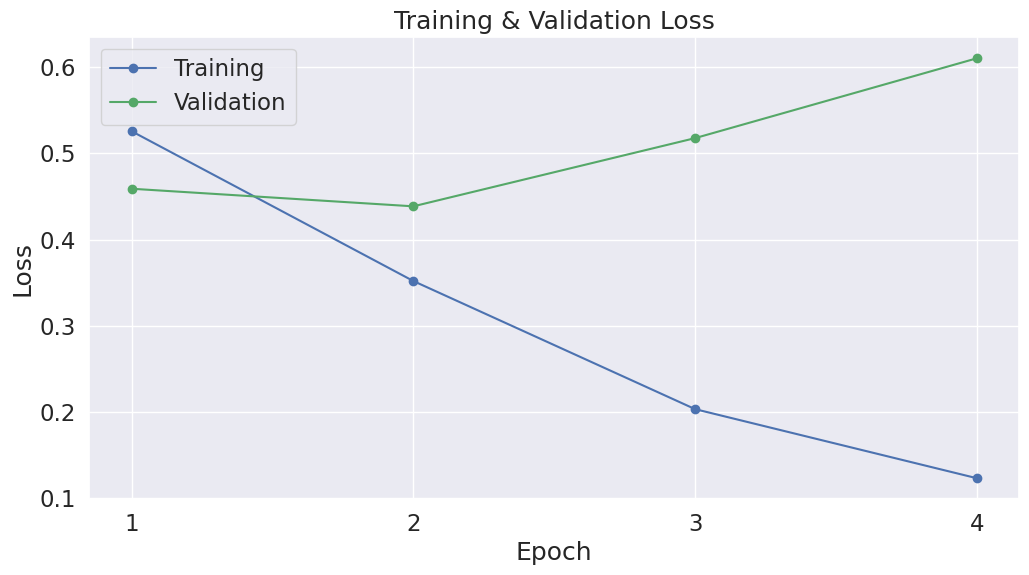

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

As we can see epoch = 2 is the best.
Let us reinitialize a model and perform training process with two epochs only.

In [88]:
model = BertForSequenceClassification.from_pretrained(
    "ai-forever/ruBert-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [89]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [90]:
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader_RuCoLa) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [91]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42
seed_everything(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader_RuCoLa):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader_RuCoLa), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        res = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader_RuCoLa)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader_RuCoLa:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            res = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader_RuCoLa)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader_RuCoLa)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:15.
  Batch    80  of    222.    Elapsed: 0:00:30.
  Batch   120  of    222.    Elapsed: 0:00:45.
  Batch   160  of    222.    Elapsed: 0:01:00.
  Batch   200  of    222.    Elapsed: 0:01:15.

  Average training loss: 0.53
  Training epcoh took: 0:01:23

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.48
  Validation took: 0:00:03

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:15.
  Batch    80  of    222.    Elapsed: 0:00:30.
  Batch   120  of    222.    Elapsed: 0:00:45.
  Batch   160  of    222.    Elapsed: 0:01:00.
  Batch   200  of    222.    Elapsed: 0:01:14.

  Average training loss: 0.38
  Training epcoh took: 0:01:22

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.46
  Validation took: 0:00:03

Training complete!
Total training took 0:02:51 (h:mm:ss)


In [92]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.528993,0.477378,0.794934,0:01:23,0:00:03
2,0.377296,0.463950,0.807829,0:01:22,0:00:03


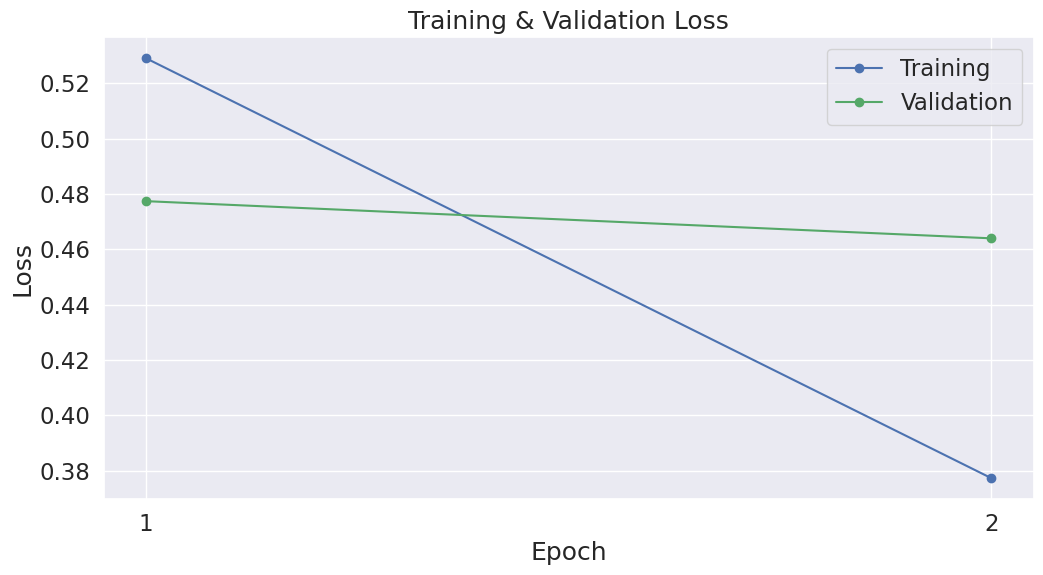

In [93]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2])

plt.show()

### 2.3 Evaluation of the fine-tuned model

Now we will load the holdout dataset and prepare inputs just as we did with the training set. Then we wil evaluate predictions using **[accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)** and **[MCC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)**. MCC is used by the wider NLP community to evaluate performance on RuCoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [94]:
# Load the test dataset into a pandas dataframe.
df_ts_RuCoLa = pd.read_csv(f"./{directory}/{files_to_download[1]}")

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_ts_RuCoLa.shape[0]))

# Create sentence and label lists
sentences_ts_RuCoLa = df_ts_RuCoLa.sentence.values
labels_ts_RuCoLa = df_ts_RuCoLa.acceptable.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences_ts_RuCoLa:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_ts_RuCoLa)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 983



### Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [95]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 983 test sentences...
    DONE.


We use MCC here because the classes are imbalanced.


In [96]:
print('Positive samples: %d of %d (%.2f%%)' % (df_ts_RuCoLa.acceptable.sum(), len(df_ts_RuCoLa.acceptable), (df_ts_RuCoLa.acceptable.sum() / len(df_ts_RuCoLa.acceptable) * 100.0)))

Positive samples: 733 of 983 (74.57%)


In [97]:
from sklearn.metrics import matthews_corrcoef, accuracy_score

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


Now we'll combine the results for all of the batches and calculate our final MCC score.

In [98]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
# Calculate the accuracy
accuracy = accuracy_score(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)
print('Accuracy: %.3f' % accuracy)

Total MCC: 0.354
Accuracy: 0.788


###  Fine-tune RuBERT: Save model


In [99]:
import os
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_ruBERT_2ep/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save_ruBERT_2ep/


('./model_save_ruBERT_2ep/tokenizer_config.json',
 './model_save_ruBERT_2ep/special_tokens_map.json',
 './model_save_ruBERT_2ep/vocab.txt',
 './model_save_ruBERT_2ep/added_tokens.json',
 './model_save_ruBERT_2ep/tokenizer.json')

In [100]:
# Obtain the model files on the colab system data
from os import listdir
from os.path import isfile, join
from google.colab import files

onlyfiles = [f for f in listdir(output_dir) if isfile(join(output_dir, f))]
print(onlyfiles)

['vocab.txt', 'special_tokens_map.json', 'tokenizer_config.json', 'tokenizer.json', 'pytorch_model.bin', 'config.json']


In [101]:
# Download the model to the local disk
for file in onlyfiles:
  files.download(f'{output_dir}{file}')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###  Fine-tune RuBERT: Conclusion
This post demonstrates that with a pre-trained RuBERT model it is possible to create a good quality model with minimal effort and training time:
- Total training took 0:02:51 (h:mm:ss)
- Total MCC: 0.354
- Accuracy: 0.788

 ### 3. Fine-tune mBERT on RuCoLa

### 3.1. Preprocess data for mBERT usage

In [102]:
from transformers import AutoTokenizer

# Load the mBERT tokenizer.
print('Loading mBERT tokenizer...')
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
print('Completed!')


# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences_tr_RuCoLa:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        truncation = True,
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_tr_RuCoLa)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences_tr_RuCoLa[0])
print('Token IDs:', input_ids[0])

#/****************/

Loading mBERT tokenizer...


Completed!
Original:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Token IDs: tensor([   101,    511,  83038,  10823,    557, 108654,  27100,  13012, 105283,
         90428,  10297,  60366,  10179,    543,  43841,    117,    549,  10122,
         13571,  89068,  41200,  10439,  68070,  58224,  10475,  12029,  48310,
           561,  10191,  98614,    117,  25484,  65891,  10227,  26325,  10625,
         10332,    552,  16657,  11050,  30621,    117,    549,  10297,  63596,
         69914,  10674,  18131,  10227,  12634,  12118,  30336,    119,    102,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])


### 3.2. Fine-tune mBERT on RuCoLa

7,082 training samples
  787 validation samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

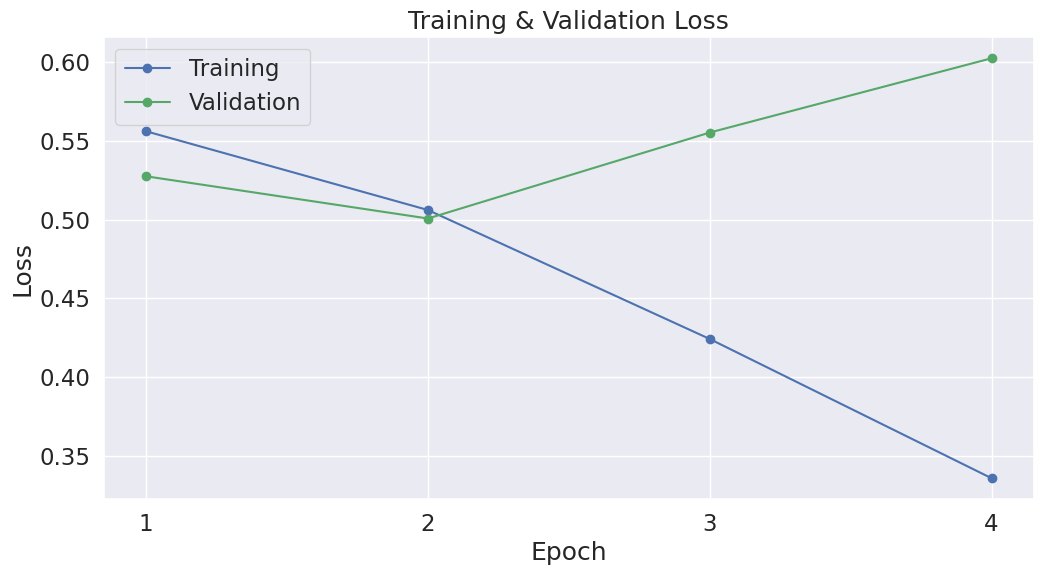

In [103]:
seed_everything(42)
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset_tr_RuCoLa, val_dataset_tr_RuCoLa = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

#/*****************/
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader_tr_RuCoLa = DataLoader(
            train_dataset_tr_RuCoLa,  # The training samples.
            sampler = RandomSampler(train_dataset_tr_RuCoLa), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader_tr_RuCoLa = DataLoader(
            val_dataset_tr_RuCoLa, # The validation samples.
            sampler = SequentialSampler(val_dataset_tr_RuCoLa), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#/********************************/

from transformers import AdamW, BertConfig, BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
# model = AutoModelForMaskedLM.from_pretrained(
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader_tr_RuCoLa) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42
seed_everything(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader_tr_RuCoLa):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader_tr_RuCoLa), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        res = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader_tr_RuCoLa)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader_tr_RuCoLa:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            res = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader_tr_RuCoLa)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader_tr_RuCoLa)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


# import pandas as pd

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
display(df_stats)

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### 3.3. Evaluation on test data`in_domain_dev.csv`


In [104]:
import pandas as pd

# # Load the test dataset into a pandas dataframe.
# df = pd.read_csv(f"./{directory}/{files_to_download[1]}")

# # Report the number of sentences.
# print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# # Create sentence and label lists
# sentences = df.sentence.values
# labels = df.acceptable.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences_ts_RuCoLa:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_ts_RuCoLa)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Evaluate on test

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')


print('Positive samples: %d of %d (%.2f%%)' % (df_ts_RuCoLa.acceptable.sum(), len(df_ts_RuCoLa.acceptable), (df_ts_RuCoLa.acceptable.sum() / len(df_ts_RuCoLa.acceptable) * 100.0)))


# /*************/

from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
# Calculate the accuracy
accuracy = accuracy_score(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)
print('Accuracy: %.3f' % accuracy)


# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_mBERT_RuC/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Predicting labels for 983 test sentences...
    DONE.
Positive samples: 733 of 983 (74.57%)
Calculating Matthews Corr. Coef. for each batch...
Total MCC: 0.360
Accuracy: 0.781
Saving model to ./model_save_mBERT_RuC/


('./model_save_mBERT_RuC/tokenizer_config.json',
 './model_save_mBERT_RuC/special_tokens_map.json',
 './model_save_mBERT_RuC/vocab.txt',
 './model_save_mBERT_RuC/added_tokens.json',
 './model_save_mBERT_RuC/tokenizer.json')

###  Fine-tune mBERT: Conclusion
This post demonstrates that with a pre-trained mBERT model it is possible to create a good quality model with minimal effort and training time:
- Total training took 0:05:43 (h:mm:ss)
- Total MCC: 0.360
- Accuracy: 0.781

### 4. Fine-tune mBERT on RuCoLa + CoLa

### Dataset augmentation: RuCoLa + CoLa

This section is devoted to augmentation of the training data (RuCoLa) with English examples from CoLa dataset.

In [105]:
# The URL for the dataset files
url_common = 'https://raw.githubusercontent.com/nyu-mll/CoLA-baselines/master/acceptability_corpus/cola_public/raw/'

files_to_download = ['in_domain_train.tsv']

# Download the files (if we haven't already)
directory = 'fp_part2_data' # folder to save dataset files
for file in files_to_download:
  if not os.path.exists(f'./{directory}'):
    os.mkdir(f'./{directory}/')
    print("Directory '% s' created \n" % directory)

  if not os.path.exists(f'./{directory}/{file}'):
    url = url_common + file
    print(f'Downloading dataset "{file}" ...')
    wget.download(url, f'./{directory}/')
    print(f'Completed!\n')

Completed!



In [106]:
# Load the dataset into a pandas dataframe.
df_tr_CoLa = pd.read_csv(f"./{directory}/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df_tr_RuCoLa = pd.read_csv(f"./{directory}/in_domain_train.csv")

In [107]:
df_tr_RuCoLa.sample(3)

,id,sentence,acceptable,error_type,detailed_source
7794,7794,В Белоруссии либеральные газеты не остались.,0,Semantics,Paducheva2013
503,503,"Иван хочет, чтобы Петр пригласил его к себе.",1,0,Testelets
6496,6496,Дубровский назначил Кистеневскую рощу местом с...,1,0,Paducheva2004


In [108]:
df_tr_CoLa.sample(3)

,sentence_source,label,label_notes,sentence
4758,ks08,1,NaN,You can rely on Edward's help.
4789,ks08,1,NaN,he had been reading the article.
454,bc01,0,*,I wonder who what bought?


Let us concatenate RuCoLa and CoLa, before that we will drop redundant columns, rename column `label` to `acceptable`.

In [109]:
df_tr_RuCoLa.drop(columns=['id', 'error_type', 'detailed_source'], inplace=True)

In [110]:
df_tr_CoLa.drop(columns=['sentence_source', 'label_notes'], inplace=True)

In [111]:
df_tr_CoLa = df_tr_CoLa[['sentence', 'label']]
df_tr_CoLa.rename(columns={'label': 'acceptable'}, inplace=True)

In [112]:
df_tr_RuCoLa_CoLa = pd.concat([df_tr_RuCoLa, df_tr_CoLa])
assert df_tr_RuCoLa_CoLa.shape[0] == (df_tr_RuCoLa.shape[0] + df_tr_CoLa.shape[0])

In [113]:
# Get the lists of sentences and their labels.
sentences_tr_RuCoLa_CoLa = df_tr_RuCoLa_CoLa.sentence.values
labels_tr_RuCoLa_CoLa = df_tr_RuCoLa_CoLa.acceptable.values
sentences_tr_RuCoLa_CoLa[7865:7873] # some Russian and English sentences

array(['Конечно, против такой системы ценностей решительно ополчились совдеповские образованцы, отвергавшие какие-либо традиции, а тем более столь возвышенные.',
       'Симптомов болезни не исчезло.',
       'Послезавтра температура у больного снижается до нормы.',
       'Говоря, например, о картине Александра Иванова «Явление Христа народу», он восхищается ею прежде всего как народной картиной, начисто отвергая какие-либо мистико-религиозные ее толкования.',
       "Our friends won't buy this analysis, let alone the next one we propose.",
       "One more pseudo generalization and I'm giving up.",
       "One more pseudo generalization or I'm giving up.",
       'The more we study verbs, the crazier they get.'], dtype=object)

### 4.2. Fine-tune mBERT on RuCoLa + CoLa

In [114]:
# Load the mBERT tokenizer.
print('Loading mBERT tokenizer...')
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
print('Completed!')

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences_tr_RuCoLa_CoLa:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        truncation = True,
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_tr_RuCoLa_CoLa)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences_tr_RuCoLa_CoLa[0])
print('Token IDs:', input_ids[0])

#/****************/


seed_everything(42)
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset_tr_RuCoLa_CoLa, val_dataset_tr_RuCoLa_CoLa = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

#/*****************/
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader_tr_RuCoLa_CoLa = DataLoader(
            train_dataset_tr_RuCoLa_CoLa,  # The training samples.
            sampler = RandomSampler(train_dataset_tr_RuCoLa_CoLa), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader_tr_RuCoLa_CoLa = DataLoader(
            val_dataset_tr_RuCoLa_CoLa, # The validation samples.
            sampler = SequentialSampler(val_dataset_tr_RuCoLa_CoLa), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#/********************************/

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
# model = AutoModelForMaskedLM.from_pretrained(
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader_tr_RuCoLa_CoLa) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42
seed_everything(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader_tr_RuCoLa_CoLa):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader_tr_RuCoLa_CoLa), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        res = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader_tr_RuCoLa_CoLa)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader_tr_RuCoLa_CoLa:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            res = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader_tr_RuCoLa_CoLa)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader_tr_RuCoLa_CoLa)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Loading mBERT tokenizer...
Completed!
Original:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Token IDs: tensor([   101,    511,  83038,  10823,    557, 108654,  27100,  13012, 105283,
         90428,  10297,  60366,  10179,    543,  43841,    117,    549,  10122,
         13571,  89068,  41200,  10439,  68070,  58224,  10475,  12029,  48310,
           561,  10191,  98614,    117,  25484,  65891,  10227,  26325,  10625,
         10332,    552,  16657,  11050,  30621,    117,    549,  10297,  63596,
         69914,  10674,  18131,  10227,  12634,  12118,  30336,    119,    102,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])
14,778 training samples
1,642 validation samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.568182,0.566430,0.740625,0:02:53,0:00:06
2,0.478185,0.513530,0.773077,0:02:52,0:00:06
3,0.381134,0.555878,0.777284,0:02:52,0:00:06
4,0.301472,0.593291,0.780889,0:02:52,0:00:06


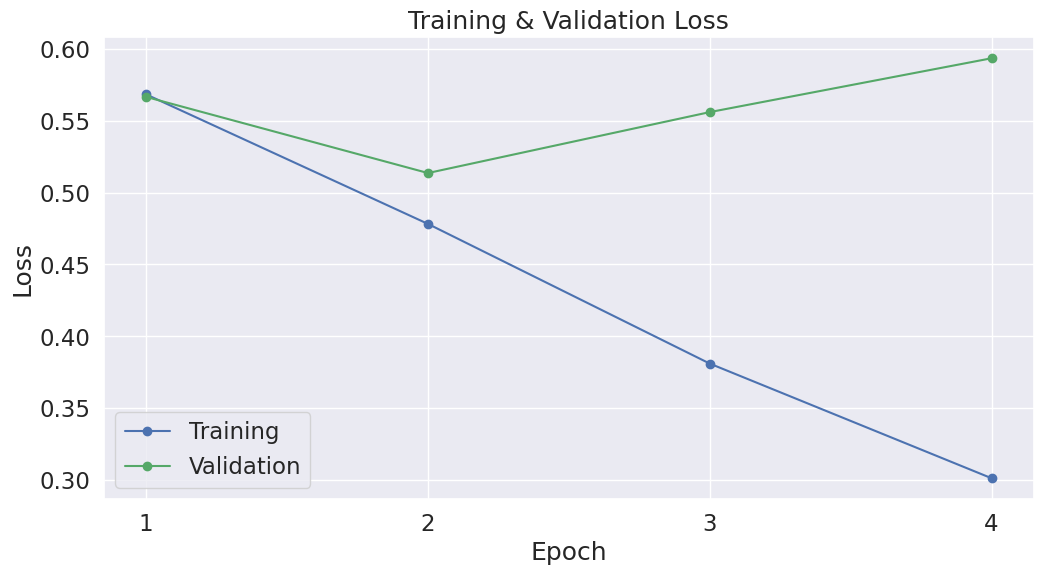

In [115]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
display(df_stats)


# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
#
# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()



### 4.3. Evaluation on test data`in_domain_dev.csv`


In [116]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences_ts_RuCoLa:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_ts_RuCoLa)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Evaluate on test

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')


print('Positive samples: %d of %d (%.2f%%)' % (df_ts_RuCoLa.acceptable.sum(), len(df_ts_RuCoLa.acceptable), (df_ts_RuCoLa.acceptable.sum() / len(df_ts_RuCoLa.acceptable) * 100.0)))


# /*************/

from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
# Calculate the accuracy
accuracy = accuracy_score(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)
print('Accuracy: %.3f' % accuracy)


import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_mBERT_RuC_CoL/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Predicting labels for 983 test sentences...
    DONE.
Positive samples: 733 of 983 (74.57%)
Calculating Matthews Corr. Coef. for each batch...
Total MCC: 0.387
Accuracy: 0.797
Saving model to ./model_save_mBERT_RuC_CoL/


('./model_save_mBERT_RuC_CoL/tokenizer_config.json',
 './model_save_mBERT_RuC_CoL/special_tokens_map.json',
 './model_save_mBERT_RuC_CoL/vocab.txt',
 './model_save_mBERT_RuC_CoL/added_tokens.json',
 './model_save_mBERT_RuC_CoL/tokenizer.json')

###  Fine-tune mBERT on RuCoLa + CoLa: Conclusion
This post demonstrates that with a pre-trained mBERT model it is possible to create a good quality model with minimal effort and training time:
- Total training took 0:11:53 (h:mm:ss)
- Total MCC: 0.387
- Accuracy: 0.797

### 5. Summary & results analysis


### 5.1. Compare the results


Let us populate the following `table 1` with all the data we obtained.

Table 1

|id|Model|Corpus|Accuracy|MCC|
|--|:--|:--:|:--:|:--:|
|1|RuBERT|RuCoLa|0.788|0.354 |
|2|mBERT|RuCoLa|0.781|0.360 |
|3|mBERT|RuCoLa + CoLa|0.797|0.387|

**RuBERT** was pre-trained on the Russian part of Wikipedia (and some other sources) to solve downstream tasks using the Russian language.

**mBERT** is a multilingual-cased version of BERT and theoretically can solve downstream tasks using many languages.

On the same corpus (RuCoLa) RuBERT demonstrated slightly higher results than mBERT since the latter is widely diversified across languages, but as soon as we enriched the corpus RuCoLa with its English variant CoLa we got significantly higher results for mBERT: the training dataset was expanded and mBERT had an oppurtunity to show its effectiveness. 

Let us populate the following `table 2` with top-3 models on [RuCoLa leaderboard](https://rucola-benchmark.com/leaderboard) (data is taken for `Machine`
 in the `by source` tab).

Table 2

|Rank|Model|Accuracy|MCC|
|:--:|:--|:--:|:--:|
|1|**Human Benchmark**|0.85|0.67|
|2|**ruRoBERTa-v4**|0.82|0.59|
|3|**ruRoBERTa-v3**|0.81|0.58|


Comparing tables 1 and 2, we may come to the conclusion that our mBERT (trained on RuCoLa+CoLa) demonstrated quite good accuracy, but the MCC result is expectedly not even close to the top-3 on leaderboard. 

### 5.2. Way of possible improvement of the model score

Due to lack of computational resources I had to use GPU provided free of charge by Google Colab. Practically GPU was available only for an hour and a half during the day. Therefore, I was limited with number of epochs to set for the trainig purposes.
I believe there are at least 3 ways to improve the quality metric of the model:
- change the number of layers;
- try to use another optimizer to obtain a minimum of the loss function more accurately;
- extend training dataset.